In [1]:
import numpy as np
import random
from collections import deque
from programmable_cubes_UDP import programmable_cubes_UDP, ProgrammableCubes

PROBLEM = "ISS"
NUM_CUBES = 148
MOVES = 6
MAX_COMMANDS = 200  # For greedy initialization

# set seed for reproducibility
random.seed(42)

#############################
# Data Loading & Metrics
#############################

def load_initial_data():
    config = np.load(f'data/{PROBLEM}/Initial_Config.npy')
    cube_types = np.load(f'data/{PROBLEM}/Initial_Cube_Types.npy')
    return config, cube_types

def load_target_data():
    target_config = np.load(f'data/{PROBLEM}/Target_Config.npy')
    target_cube_types = np.load(f'data/{PROBLEM}/Target_Cube_Types.npy')
    target_positions_by_type = {}
    for t in np.unique(target_cube_types):
        target_positions_by_type[t] = set(tuple(pos) for pos in target_config[target_cube_types == t])
    return target_config, target_cube_types, target_positions_by_type

def compute_overlap_fraction(cubes, init_cube_types, target_config, target_cube_types):
    num_correct = 0
    num_total = len(cubes.cube_position)
    for t in np.unique(target_cube_types):
        target_set = set(tuple(pos) for pos in target_config[target_cube_types == t])
        current_set = set(tuple(pos) for pos in cubes.cube_position[init_cube_types == t])
        num_correct += sum(1 for pos in target_set if pos in current_set)
    return num_correct / num_total

def compute_total_distance(cubes, init_cube_types, target_config, target_cube_types):
    total = 0.0
    for i, pos in enumerate(cubes.cube_position):
        t = init_cube_types[i]
        valid_positions = list(set(tuple(p) for p in target_config[target_cube_types == t]))
        valid_array = np.array(valid_positions)
        if tuple(pos) in valid_positions:
            continue
        dists = np.linalg.norm(valid_array - pos, axis=1)
        total += np.min(dists)
    return total

def evaluate(chromosome, udp):
    """Evaluate a chromosome using udp.fitness (reverse sign so higher is better)."""
    return -udp.fitness(chromosome)[0]

#############################
# Chromosome Conversion Helpers
#############################

def convert_to_chrom(moves):
    """
    Convert a list of (cube_id, move) pairs into a NumPy array chromosome,
    with a termination marker (-1) appended.
    """
    chrom = []
    for cube_id, move in moves:
        chrom.extend([cube_id, move])
    chrom.append(-1)
    return np.array(chrom)

def extract_moves(chromosome):
    """
    Convert a NumPy array chromosome (ending with -1) to a list of (cube_id, move) pairs.
    """
    return [(chromosome[i], chromosome[i+1]) for i in range(0, len(chromosome)-1, 2)]

#############################
# GREEDY INITIAL SOLUTION
#############################

def greedy_initial_solution(max_moves=MAX_COMMANDS, improvement_threshold=1e-4, verbose=True):
    initial_positions, initial_cube_types = load_initial_data()
    target_config, target_cube_types, _ = load_target_data()
    
    cubes = ProgrammableCubes(initial_positions)
    chromosome = []
    current_overlap = compute_overlap_fraction(cubes, initial_cube_types, target_config, target_cube_types)
    current_distance = compute_total_distance(cubes, initial_cube_types, target_config, target_cube_types)
    if verbose:
        print(f"Initial overlap fraction: {current_overlap:.4f}, total distance: {current_distance:.4f}")
    
    for move_count in range(max_moves):
        best_improvement = -np.inf
        best_move = None
        for cube_id in range(NUM_CUBES):
            valid_set = set(tuple(p) for p in target_config[target_cube_types == initial_cube_types[cube_id]])
            if tuple(cubes.cube_position[cube_id]) in valid_set:
                continue
            for move in range(MOVES):
                clone = ProgrammableCubes(np.copy(cubes.cube_position))
                if clone.apply_single_update_step(cube_id, move) == 1:
                    new_overlap = compute_overlap_fraction(clone, initial_cube_types, target_config, target_cube_types)
                    new_distance = compute_total_distance(clone, initial_cube_types, target_config, target_cube_types)
                    improvement = 0.9 * (new_overlap - current_overlap) + 0.1 * (current_distance - new_distance)
                    if improvement > best_improvement:
                        best_improvement = improvement
                        best_move = (cube_id, move)
        if best_move and best_improvement > improvement_threshold:
            cube_id, move = best_move
            if cubes.apply_single_update_step(cube_id, move) == 1:
                chromosome.extend([cube_id, move])
                current_overlap = new_overlap
                current_distance = new_distance
                if verbose:
                    print(f"Move {move_count}: applied cube {cube_id} with move {move}. New overlap: {current_overlap:.4f}, total distance: {current_distance:.4f}")
            else:
                if verbose:
                    print("Best move became illegal. Breaking out.")
                break
        else:
            if verbose:
                print(f"No improving move found at iteration {move_count}")
            break
    if not chromosome or chromosome[-1] != -1:
        chromosome.append(-1)
    return np.array(chromosome, dtype=np.int32)

#############################
# GREEDY LOOKAHEAD EXTENSION
#############################

def greedy_lookahead_extension(current_solution, udp, lookahead=2, improvement_threshold=1e-3, candidate_sample_size=10):
    """
    Starting from current_solution, for a subset of candidate cubes (not yet at valid targets),
    sample random move sequences of length 'lookahead'. For each candidate extension,
    append the sequence to the current solution and evaluate UDP.fitness.
    Return the candidate full solution that yields the best improvement if it beats current fitness by at least improvement_threshold;
    otherwise, return None.
    """
    init_config, cube_types = load_initial_data()
    target_config, target_cube_types, target_positions_by_type = load_target_data()
    
    cubes = ProgrammableCubes(np.copy(init_config))
    _ = cubes.apply_chromosome(current_solution, verbose=False)
    current_fitness = evaluate(current_solution, udp)
    
    candidate_indices = []
    for i in range(len(cubes.cube_position)):
        if tuple(cubes.cube_position[i]) not in target_positions_by_type[cube_types[i]]:
            candidate_indices.append(i)
    if len(candidate_indices) > candidate_sample_size:
        candidate_indices = random.sample(candidate_indices, candidate_sample_size)
    
    best_candidate_fitness = current_fitness
    best_extension = None
    best_candidate_solution = None
    
    for cube_id in candidate_indices:
        for _ in range(10):
            seq = tuple(random.randint(0, 5) for _ in range(lookahead))
            candidate_extension = [(cube_id, m) for m in seq]
            candidate_chrom = np.concatenate([current_solution[:-1], convert_to_chrom(candidate_extension)])
            candidate_fitness = evaluate(candidate_chrom, udp)
            if candidate_fitness > best_candidate_fitness:
                best_candidate_fitness = candidate_fitness
                best_extension = candidate_extension
                best_candidate_solution = candidate_chrom
    if best_candidate_solution is not None and best_candidate_fitness > current_fitness + improvement_threshold:
        return best_candidate_solution, best_candidate_fitness
    else:
        return None, current_fitness

def iterative_lookahead_extension(initial_solution, udp, max_iterations=20, improvement_threshold=1e-3, candidate_sample_size=10):
    """
    Iteratively applies the greedy lookahead extension operator.
    Start with lookahead=2. If no improvement is found for 3 consecutive iterations,
    increase lookahead by 1 (up to a maximum of 5). When an extension is accepted, reset lookahead to 2.
    """
    current_solution = initial_solution.copy()
    current_fitness = evaluate(current_solution, udp)
    print(f"Starting lookahead extension. Initial fitness: {current_fitness:.4f}")
    
    iteration = 0
    current_lookahead = 2
    no_improve_count = 0
    
    while iteration < max_iterations:
        candidate_solution, candidate_fitness = greedy_lookahead_extension(
            current_solution, udp,
            lookahead=current_lookahead,
            improvement_threshold=improvement_threshold,
            candidate_sample_size=candidate_sample_size
        )
        if candidate_solution is not None and candidate_fitness > current_fitness + improvement_threshold:
            current_solution = candidate_solution.copy()
            current_fitness = candidate_fitness
            print(f"Iteration {iteration}: Improved fitness to {current_fitness:.4f} (lookahead={current_lookahead})")
            no_improve_count = 0
            current_lookahead = 2
        else:
            no_improve_count += 1
            print(f"Iteration {iteration}: No improvement with lookahead={current_lookahead} (consecutive no-improve count = {no_improve_count})")
            if no_improve_count >= 3:
                if current_lookahead < 10:
                    current_lookahead += 1
                    print(f"Increasing lookahead to {current_lookahead} after 3 consecutive non-improving iterations.")
                    no_improve_count = 0
                else:
                    print(f"No improvement with lookahead={current_lookahead} for 3 consecutive iterations. Terminating lookahead extension.")
                    break
        iteration += 1
    return current_solution, current_fitness

#############################
# FINAL POLISHING BFS (SINGLE-CUBE)
#############################

def single_cube_bfs_move_sequence(current_chromosome, cube_id, valid_target_positions, udp, max_depth=12):
    """
    Attempt to find a short BFS path (up to max_depth moves) that repositions 'cube_id'
    into one of the valid_target_positions (for its type), keeping other cubes fixed.
    Returns a list of (cube_id, move) pairs representing the BFS path, or None if not found.
    """
    init_config, _ = load_initial_data()
    cubes = ProgrammableCubes(init_config.copy())
    cubes.apply_chromosome(current_chromosome, verbose=False)
    start_pos = tuple(cubes.cube_position[cube_id])
    if start_pos in valid_target_positions:
        return []
    
    visited = set()
    queue = deque()
    start_positions = cubes.cube_position.copy()
    start_node = (start_positions, [])
    
    def positions_to_key(positions):
        return tuple(tuple(pos) for pos in positions)
    
    visited.add(positions_to_key(start_positions))
    queue.append(start_node)
    
    depth = 0
    while queue and depth <= max_depth:
        level_size = len(queue)
        for _ in range(level_size):
            pos_array, path = queue.popleft()
            if tuple(pos_array[cube_id]) in valid_target_positions:
                return path
            for m in range(6):
                new_positions = pos_array.copy()
                clone = ProgrammableCubes(new_positions)
                if clone.apply_single_update_step(cube_id, m) == 1:
                    key = positions_to_key(clone.cube_position)
                    if key not in visited:
                        visited.add(key)
                        new_path = path + [(cube_id, m)]
                        queue.append((clone.cube_position.copy(), new_path))
        depth += 1
    return None

def place_one_cube_bfs(global_solution, cube_id, valid_target_positions, udp, max_depth=12):
    """
    Try BFS to reposition cube 'cube_id' into one of the valid_target_positions.
    If found, append the BFS path to global_solution and return the new solution; else, return None.
    """
    path = single_cube_bfs_move_sequence(global_solution, cube_id, valid_target_positions, udp, max_depth=max_depth)
    if path is not None:
        extended = np.concatenate([global_solution[:-1], np.array([x for pair in path for x in pair]), [-1]])
        return extended
    return None

def final_polishing_bfs(global_solution, udp, max_rounds=3, max_depth=12):
    """
    Iteratively attempts to reposition misplaced cubes using BFS.
    For each cube not at a valid target, try BFS (up to max_depth moves). If a BFS path is found
    that improves global UDP.fitness, update the global solution.
    Repeat for max_rounds or until no further improvements are found.
    """
    init_config, cube_types = load_initial_data()
    target_config, target_cube_types, target_positions_by_type = load_target_data()
    
    rounds = 0
    improved = True
    while improved and rounds < max_rounds:
        improved = False
        rounds += 1
        cubes = ProgrammableCubes(init_config.copy())
        cubes.apply_chromosome(global_solution, verbose=False)
        for cid in range(len(cubes.cube_position)):
            pos = tuple(cubes.cube_position[cid])
            valid_set = target_positions_by_type[cube_types[cid]]
            if pos not in valid_set:
                candidate = place_one_cube_bfs(global_solution, cid, valid_set, udp, max_depth=max_depth)
                if candidate is not None:
                    old_fit = evaluate(global_solution, udp)
                    new_fit = evaluate(candidate, udp)
                    if new_fit > old_fit:
                        global_solution = candidate
                        improved = True
                        cubes = ProgrammableCubes(init_config.copy())
                        cubes.apply_chromosome(global_solution, verbose=False)
        print(f"Round {rounds}: current fitness = {evaluate(global_solution, udp):.4f}")
    return global_solution

In [12]:
udp = programmable_cubes_UDP(PROBLEM)

# Stage 1: Greedy Initialization.
print("Generating greedy solution...")
greedy_solution = greedy_initial_solution(max_moves=MAX_COMMANDS, improvement_threshold=1e-4, verbose=True)
np.save('greedy_solution.npy', greedy_solution)
base_fit = evaluate(greedy_solution, udp)
print(f"Greedy solution saved with {(len(greedy_solution)-1)//2} moves, base fitness = {base_fit:.4f}")

Generating greedy solution...
Initial overlap fraction: 0.1486, total distance: 259.6122
Move 0: applied cube 0 with move 0. New overlap: 0.1486, total distance: 259.6122
Move 1: applied cube 17 with move 2. New overlap: 0.1554, total distance: 258.1980
Move 2: applied cube 18 with move 3. New overlap: 0.1554, total distance: 256.8285
Move 3: applied cube 47 with move 0. New overlap: 0.1554, total distance: 255.5924
Move 4: applied cube 83 with move 2. New overlap: 0.1622, total distance: 254.1782
Move 5: applied cube 86 with move 2. New overlap: 0.1622, total distance: 252.9421
Move 6: applied cube 43 with move 1. New overlap: 0.1622, total distance: 251.7061
Move 7: applied cube 93 with move 0. New overlap: 0.1622, total distance: 250.4381
Move 8: applied cube 116 with move 2. New overlap: 0.1622, total distance: 249.2021
Move 9: applied cube 37 with move 0. New overlap: 0.1622, total distance: 248.0398
Move 10: applied cube 12 with move 2. New overlap: 0.1689, total distance: 245.80

In [13]:
# Stage 2: Iterative Lookahead Extension.
print("\nStarting iterative lookahead extension...")
lookahead_solution, lookahead_fitness = iterative_lookahead_extension(greedy_solution, udp,
																		max_iterations=1000,
																		improvement_threshold=1e-3,
																		candidate_sample_size=150)
np.save('lookahead_solution.npy', lookahead_solution)
print(f"Lookahead solution fitness = {evaluate(lookahead_solution, udp):.4f}")




Starting iterative lookahead extension...
Starting lookahead extension. Initial fitness: 0.3930
Iteration 0: Improved fitness to 0.4009 (lookahead=2)
Iteration 1: Improved fitness to 0.4088 (lookahead=2)
Iteration 2: Improved fitness to 0.4167 (lookahead=2)
Iteration 3: Improved fitness to 0.4246 (lookahead=2)
Iteration 4: Improved fitness to 0.4325 (lookahead=2)
Iteration 5: Improved fitness to 0.4404 (lookahead=2)
Iteration 6: Improved fitness to 0.4483 (lookahead=2)
Iteration 7: Improved fitness to 0.4562 (lookahead=2)
Iteration 8: Improved fitness to 0.4641 (lookahead=2)
Iteration 9: No improvement with lookahead=2 (consecutive no-improve count = 1)
Iteration 10: No improvement with lookahead=2 (consecutive no-improve count = 2)
Iteration 11: No improvement with lookahead=2 (consecutive no-improve count = 3)
Increasing lookahead to 3 after 3 consecutive non-improving iterations.
Iteration 12: Improved fitness to 0.4719 (lookahead=3)
Iteration 13: No improvement with lookahead=2 (c

In [32]:
# Stage 3: Final Polishing BFS.
print("\nStarting final BFS polishing...")
polished_solution = final_polishing_bfs(lookahead_solution, udp, max_rounds=3, max_depth=12)
final_fit = evaluate(polished_solution, udp)
np.save('final_solution.npy', polished_solution)
print(f"Final solution fitness = {final_fit:.4f}")


Starting final BFS polishing...
Round 1: current fitness = 0.8551
Round 2: current fitness = 0.8783
Round 3: current fitness = 0.8860
Final solution fitness = 0.8860


MovieWriter ffmpeg unavailable; using Pillow instead.


Animation saved as ISS.gif


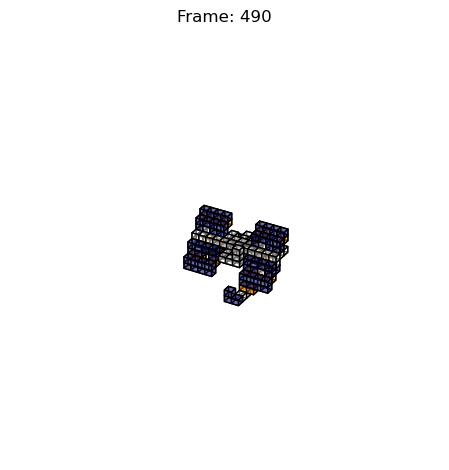

In [15]:
# import neceeessary libraries for animation
import matplotlib.pyplot as plt
import seaborn as sns
import json
from copy import deepcopy


# Load initial config and cube types for animation.
init = np.load(f'data/{PROBLEM}/Initial_Config.npy')
cube_types = np.load(f'data/{PROBLEM}/Initial_Cube_Types.npy')
cubes = ProgrammableCubes(deepcopy(init))

def coords_to_dense(positions, cube_types):
	# Create a dense tensor for 3 cube types and a 30x30x30 grid.
	cube_tensor = np.zeros((3, 30, 30, 30))
	for l in range(3):
		for pos in positions[cube_types == l]:
			i, j, k = pos
			cube_tensor[l][i+10][j+10][k+10] = 1
	return cube_tensor

# Animate: store ensemble configurations.
storage = [coords_to_dense(cubes.cube_position, cube_types)]

# Apply moves from final_solution and store each configuration.
for j in range(int(len(polished_solution) / 2)):
	cube_id = polished_solution[2*j]
	move = polished_solution[2*j+1]
	if cube_id == -1:
		break
	cubes.apply_single_update_step(cube_id, move)
	storage.append(coords_to_dense(cubes.cube_position, cube_types))

# Additional animation code:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.bbox'] = 'tight'
with open('problems/ISS.json') as infile:
	colours = json.load(infile)['colours']

fig = plt.figure(figsize=(plt.figaspect(1)))
ax = fig.add_subplot(1, 1, 1, projection='3d')
sns.despine(ax=ax, bottom=True, top=True, left=True, right=True)
ln, = ax.plot3D([0], [0], [0])
ax._axis3don = False
ax.set_facecolor('white')

def init_anim():
	return ln,

def update_anim(frame):
	ax.clear()
	for l in range(3):
		ax.voxels(storage[frame][l], facecolor=colours[l], edgecolors='k', alpha=0.4)
	ax.axis('off')
	ax.set_xticks([])
	ax.set_yticks([])
	ax.set_zticks([])
	ax.set_title(f"Frame: {frame}")
	ax._axis3don = False
	plt.tight_layout()
	return ln,

from matplotlib.animation import FuncAnimation
ani = FuncAnimation(fig, update_anim, frames=np.arange(0, len(storage), 10),
					init_func=init_anim, interval=1000., blit=True)
ani.save('ISS.gif')
print("Animation saved as ISS.gif")